# finding motivating examples for SV

In [1]:
import torch
import sys
import os
import numpy as np
from umap.umap_ import find_ab_params

from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.losses import SingleVisLoss, UmapLoss, ReconstructionLoss
from singleVis.trainer import SingleVisTrainer
from singleVis.data import DataProvider
from singleVis.visualizer import visualizer
import singleVis.config as config


In [2]:
DATASET = "cifar10"
CONTENT_PATH = "/home/xianglin/projects/DVI_data/TemporalExp/resnet18_{}".format(DATASET)

In [3]:

LEN = config.dataset_config[DATASET]["TRAINING_LEN"]
LAMBDA = config.dataset_config[DATASET]["LAMBDA"]

# define hyperparameters

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCH_NUMS = config.dataset_config[DATASET]["training_config"]["EPOCH_NUM"]
TIME_STEPS = config.dataset_config[DATASET]["training_config"]["TIME_STEPS"]
TEMPORAL_PERSISTENT = config.dataset_config[DATASET]["training_config"]["TEMPORAL_PERSISTENT"]
NUMS = config.dataset_config[DATASET]["training_config"]["NUMS"]    # how many epoch should we go through for one pass
PATIENT = config.dataset_config[DATASET]["training_config"]["PATIENT"]

content_path = CONTENT_PATH
sys.path.append(content_path)

from Model.model import *
net = resnet18()
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

data_provider = DataProvider(content_path, net, 1, TIME_STEPS, 1, split=-1, device=DEVICE, verbose=1)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256)
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA)

optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)

trainer = SingleVisTrainer(model, criterion, optimizer, lr_scheduler, edge_loader=None, DEVICE=DEVICE)
trainer.load(file_path=os.path.join(data_provider.model_path,"SV.pth"))

Finish initialization...
Successfully load visualization model...


## Find a stable sample

In [4]:
prev_data = data_provider.train_representation(4)
curr_data = data_provider.train_representation(11)

dists = np.linalg.norm(prev_data - curr_data, axis=1)
dists.shape

(50000,)

In [5]:
dists.min(), dists.mean(), dists.max(), np.argmin(dists)

(0.09759083660706683, 1.0227800147240087, 8.08314140548586, 7450)

## Visualization

In [6]:
vis_list = [7450]

100%|██████████| 250/250 [00:00<00:00, 11727.33it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12110.51it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 11932.18it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 11974.97it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12069.11it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12024.95it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12036.55it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 11955.03it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12033.37it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 11932.59it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 11955.44it/s]


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 12575.49it/s]


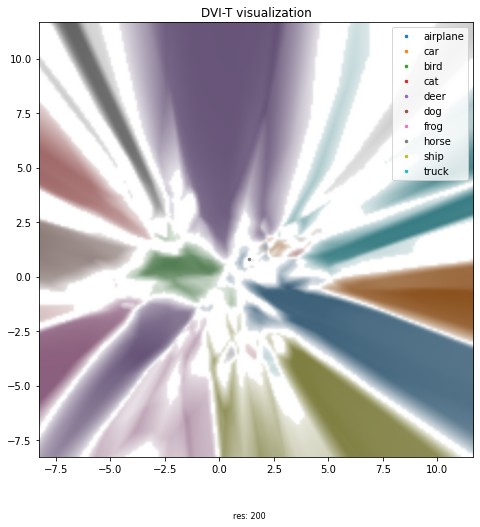

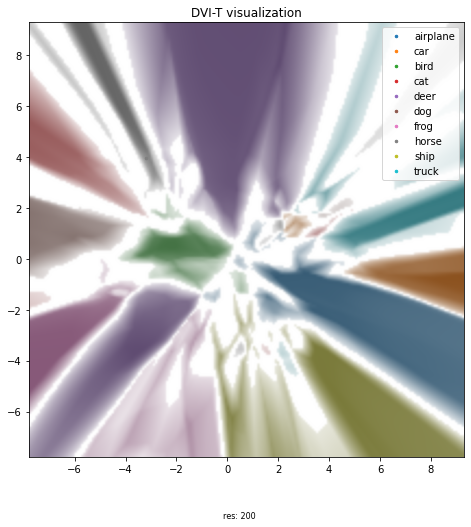

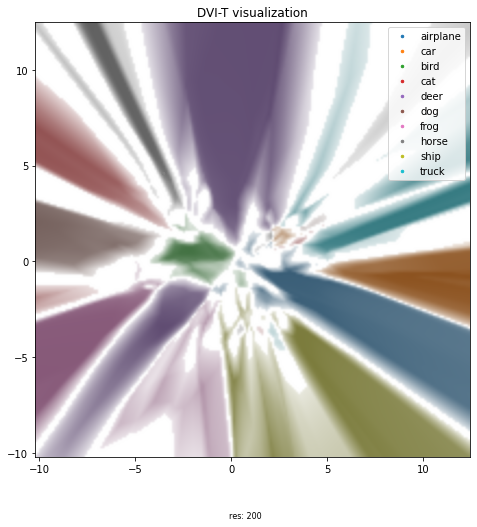

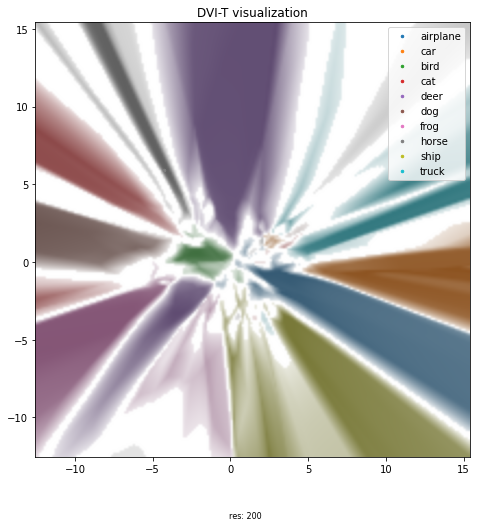

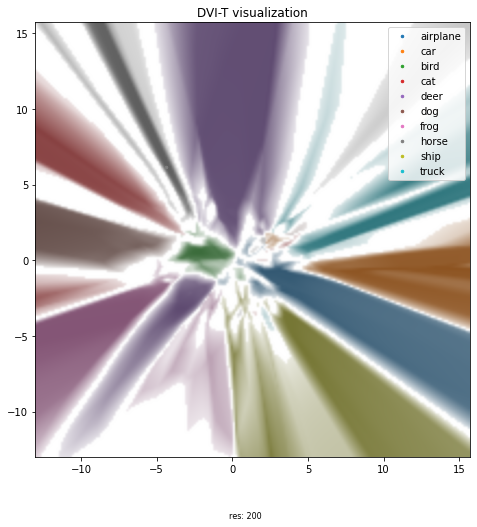

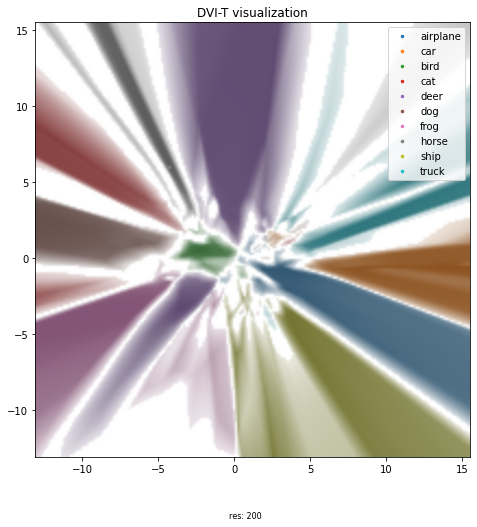

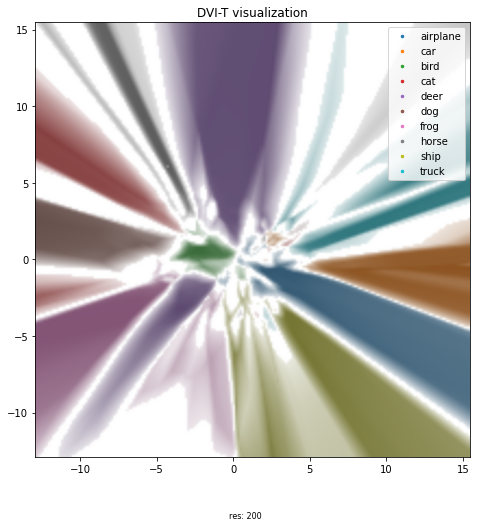

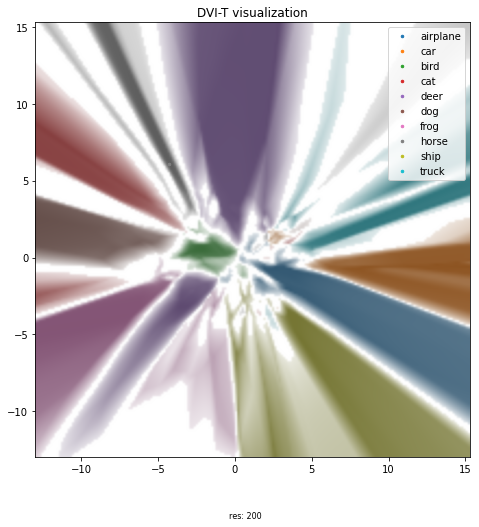

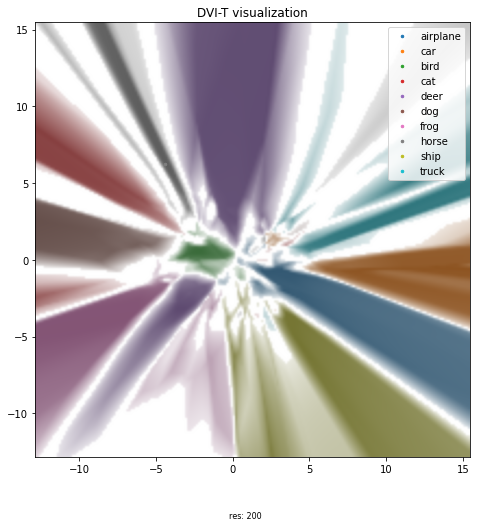

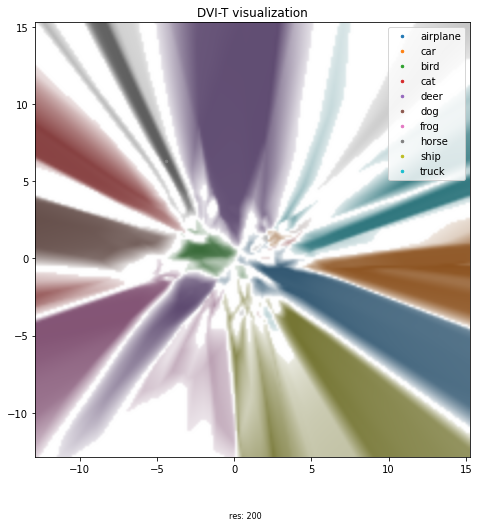

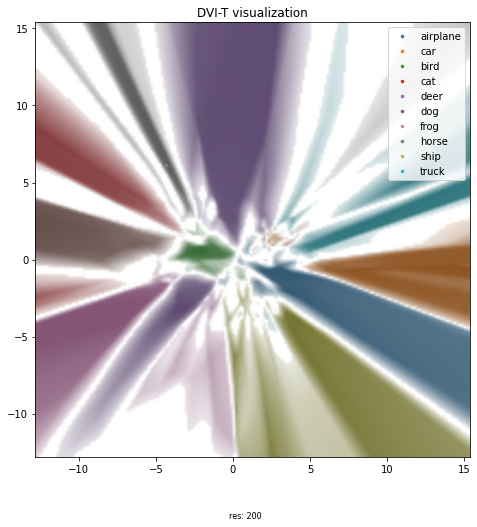

In [7]:
vis = visualizer(data_provider, trainer.model, 200, 10, classes)
save_dir = os.path.join(data_provider.content_path, "img")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for i in range(1, 12, 1):
    curr_data = data_provider.train_representation(i)
    pred = data_provider.get_pred(i, curr_data)
    pred = np.argmax(pred, axis=1)
    labels = data_provider.train_labels(i)
    vis.savefig_cus(i, curr_data[vis_list], pred[vis_list], labels[vis_list], path=os.path.join(save_dir,"motivated_{}_{}.png".format(DATASET, i)))

100%|██████████| 250/250 [00:00<00:00, 12083.15it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12152.89it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12003.07it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12112.18it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12179.57it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 11891.85it/s]


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 12131.10it/s]


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 12717.91it/s]


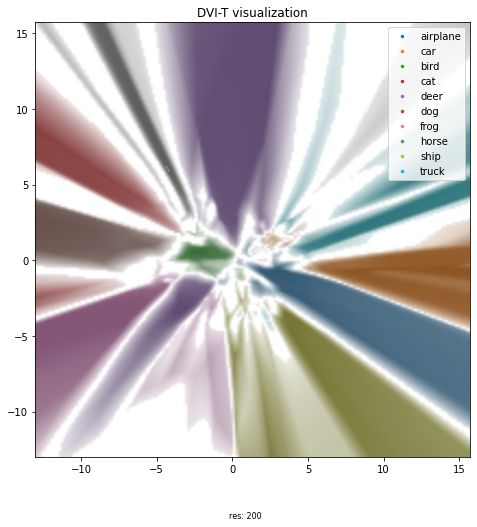

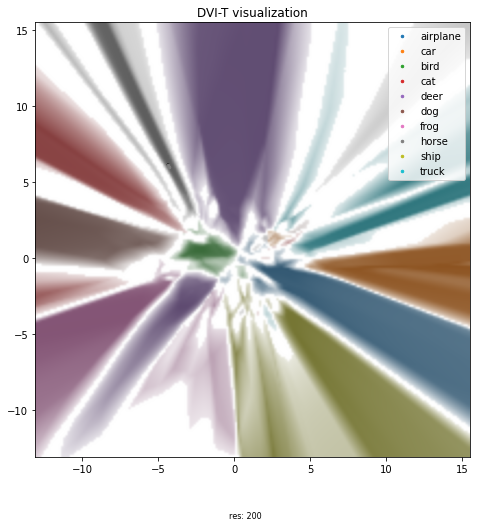

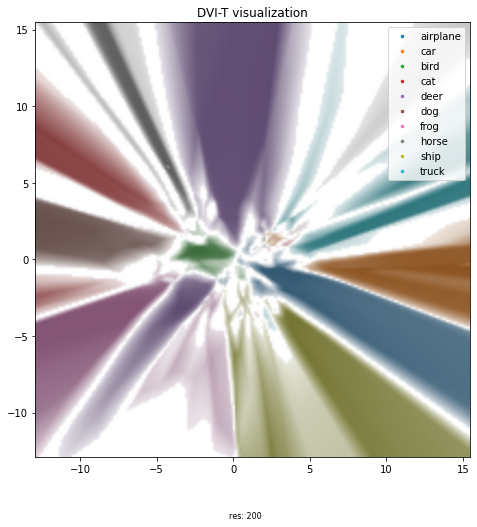

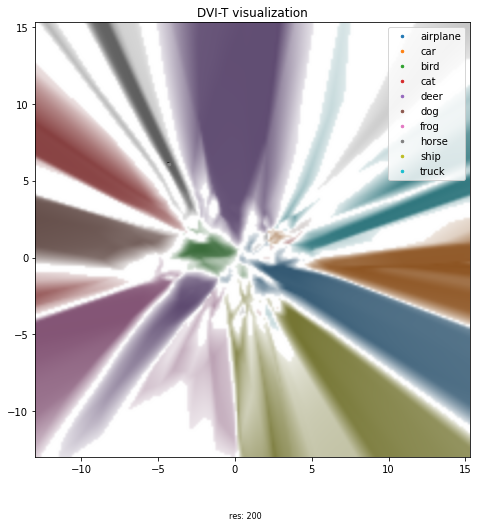

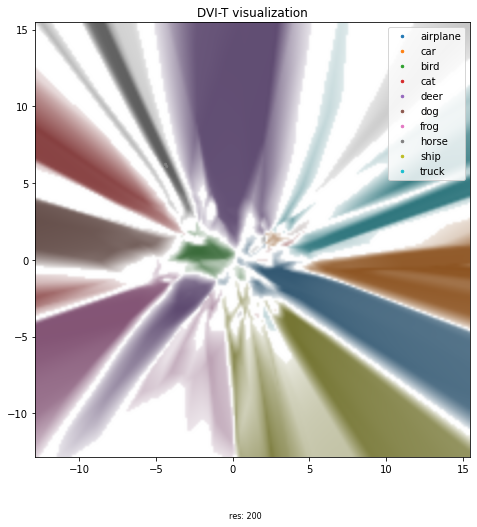

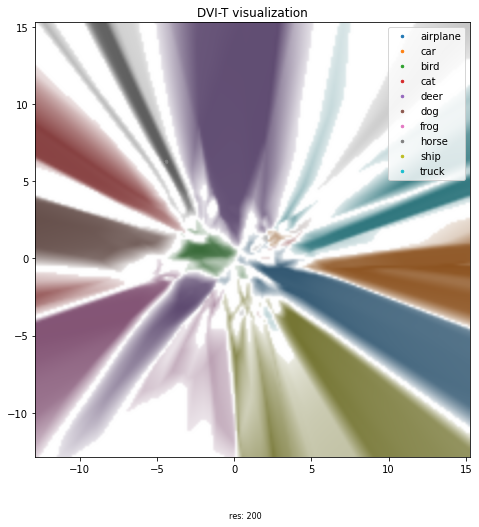

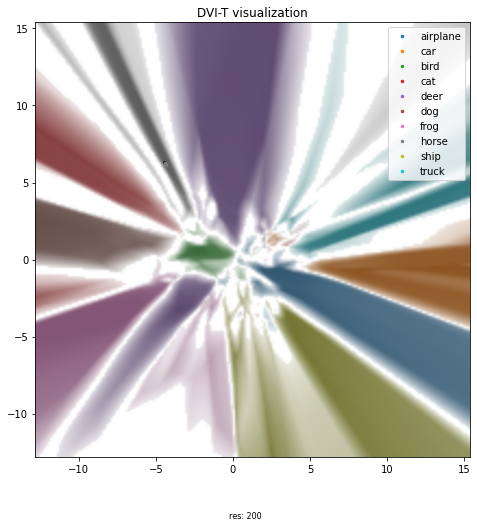

In [8]:
for i in range(5, 12, 1):
    curr_data = data_provider.train_representation(i)
    pred = data_provider.get_pred(i, curr_data)
    pred = np.argmax(pred, axis=1)
    labels = data_provider.train_labels(i)

    prev_data = data_provider.train_representation(i-1)
    prev_pred = data_provider.get_pred(i-1, prev_data)
    prev_pred = np.argmax(prev_pred, axis=1)
    prev_labels = data_provider.train_labels(i-1)

    vis.savefig_trajectory(i, prev_data[vis_list], prev_pred[vis_list], prev_labels[vis_list], curr_data[vis_list], pred[vis_list], labels[vis_list], path=os.path.join(save_dir,"motivated_{}_{}.png".format(DATASET, i)))

# visualize trajectory

In [9]:
all_data = None
embeddings = torch.Tensor([]).to("cpu")
for i in range(1, TIME_STEPS+1, 1):
    data = data_provider.train_representation(i)
    if all_data is None:
        all_data = data[:, None,:]
    else:
        all_data = np.concatenate((all_data, data[:, None, :]), axis=1)
    data = torch.from_numpy(data).to(device=data_provider.DEVICE, dtype=torch.float)
    embedding = trainer.model.encoder(data).detach().cpu()
    embeddings = torch.concat((embeddings, embedding[:, None, :]), dim=1)
embeddings = embeddings.numpy()
embeddings.shape

(50000, 11, 2)

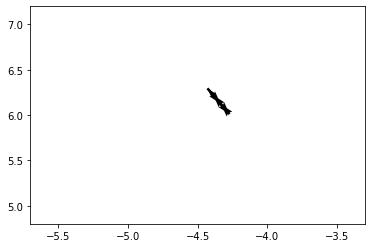

In [10]:
import singleVis.trajectory as trajectory
trajectory.draw_trajectory(embeddings[7450][4:],x_min=-5.5, x_max=-3.5, y_min=5, y_max=7)

## Ground truth of dists change and direction change

In [11]:
all_data.shape
high_dists = np.zeros((50000, 10))
for i in range(50000):
    for j in range(10):
        high_dists[i][j] = np.linalg.norm(all_data[i][j]-all_data[i][j+1])
low_dists = np.zeros((50000, 10))
for i in range(50000):
    for j in range(10):
        low_dists[i][j] = np.linalg.norm(embeddings[i][j]-embeddings[i][j+1])

In [12]:
high_dists[7450],low_dists[7450]

(array([2.57326624, 1.00739937, 0.73593734, 0.10854921, 0.17840608,
        0.12577214, 0.00976477, 0.1205381 , 0.09433073, 0.202841  ]),
 array([5.56713963e+00, 7.56942809e-01, 1.48744786e+00, 2.25224510e-01,
        1.60085335e-01, 1.18200459e-01, 4.17825580e-03, 1.23032078e-01,
        8.76737759e-02, 1.90108612e-01]))

In [13]:
from scipy.spatial import distance
high_directions = np.zeros((50000, 9))
for i in range(50000):
    for j in range(9):
        high_directions[i][j] = 1 - distance.cosine(all_data[i][j]-all_data[i][j+1], all_data[i][j+1]-all_data[i][j+2])
low_directions = np.zeros((50000, 9))
for i in range(50000):
    for j in range(9):
        low_directions[i][j] = 1 - distance.cosine(embeddings[i][j]-embeddings[i][j+1],embeddings[i][j+1]-embeddings[i][j+2])

/home/xianglin/miniconda3/envs/SV/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
high_directions[7450],low_directions[7450]

(array([-0.22461181, -0.59904386, -0.78757209, -0.32804295, -0.4315399 ,
        -0.96678122, -0.93659513,  0.73976912, -0.57688911]),
 array([-0.28222018, -0.9962824 , -0.64523488, -0.46916449,  0.18407468,
        -0.99929303, -0.98955518,  0.98536444, -0.99085128]))

# correlation betweem high dim dists and low dim dists

In [ ]:
prev_data = data_provider.train_representation(10)
curr_data = data_provider.train_representation(11)

prev_data = torch.from_numpy(prev_data).to(device=data_provider.DEVICE, dtype=torch.float)
prev_embedding = trainer.model.encoder(prev_data).detach().cpu().numpy()

curr_data = torch.from_numpy(curr_data).to(device=data_provider.DEVICE, dtype=torch.float)
curr_embedding = trainer.model.encoder(curr_data).detach().cpu().numpy()

embedding_dists = np.linalg.norm(prev_embedding-curr_embedding, axis=1)

In [ ]:
from scipy.stats.stats import pearsonr
corr = pearsonr(dists, embedding_dists)
corr

(0.06277377790167302, 7.68712352692816e-45)